In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickrfaceshq-dataset-ffhq/27147.png
/kaggle/input/flickrfaceshq-dataset-ffhq/52235.png
/kaggle/input/flickrfaceshq-dataset-ffhq/32352.png
/kaggle/input/flickrfaceshq-dataset-ffhq/41695.png
/kaggle/input/flickrfaceshq-dataset-ffhq/21130.png
/kaggle/input/flickrfaceshq-dataset-ffhq/36145.png
/kaggle/input/flickrfaceshq-dataset-ffhq/22897.png
/kaggle/input/flickrfaceshq-dataset-ffhq/18966.png
/kaggle/input/flickrfaceshq-dataset-ffhq/22069.png
/kaggle/input/flickrfaceshq-dataset-ffhq/47434.png
/kaggle/input/flickrfaceshq-dataset-ffhq/52691.png
/kaggle/input/flickrfaceshq-dataset-ffhq/32860.png
/kaggle/input/flickrfaceshq-dataset-ffhq/37825.png
/kaggle/input/flickrfaceshq-dataset-ffhq/27326.png
/kaggle/input/flickrfaceshq-dataset-ffhq/44033.png
/kaggle/input/flickrfaceshq-dataset-ffhq/43294.png
/kaggle/input/flickrfaceshq-dataset-ffhq/50028.png
/kaggle/input/flickrfaceshq-dataset-ffhq/34514.png
/kaggle/input/flickrfaceshq-dataset-ffhq/01301.png
/kaggle/input/flickrfaceshq-dat

# StyelGAN

In [3]:
import torch
import torch.nn as nn
from math import log2

## Generator

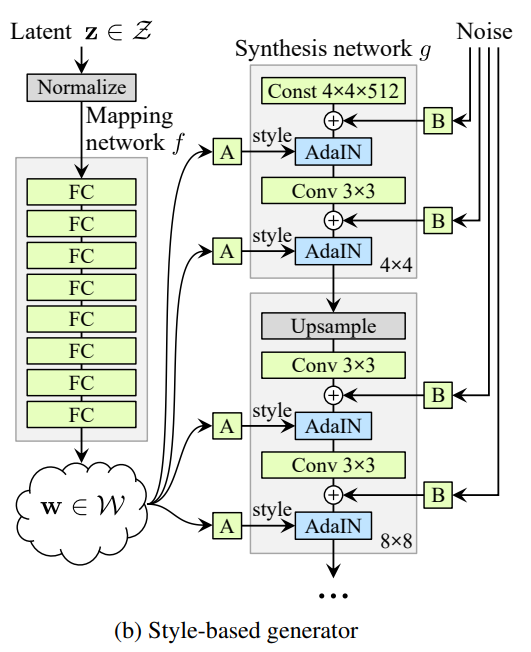

### source: [StyleGAN](https://arxiv.org/pdf/1812.04948.pdf) 

In [4]:
data_dir = "/kaggle/input"
BATCH_SIZE = BATCH_SIZES = [256,256,128,64,32,16]
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-2
Z_DIM = 512
W_DIM = 512
IN_CHANNELS = 512
LAMBDA_GP = 10
EPOCHS = 30
CHANNELS_IMG = 3
start_with_img_size = 8
IMG_SIZE = 512
SAVE_MODEL_PATH = "/kaggle/working/model"
LOAD_MODEL_PATH = "/kaggle/working/model"
load_saved_model = True

In [5]:
model = torch.load("/kaggle/input/saved-model/15.pth")

In [6]:
os.mkdir("/kaggle/working/model")
torch.save(model, "/kaggle/working/model/saved_model.pth")

## Mapping Network *f*

In [7]:
class MapNet(nn.Module):
    
    """
    Non-Linear Mapping Network which Maps Z -> W
    
    params:
        in_features: Dimension of Z
        out_featues: Dimenstion of W
    """
    
    def __init__(self, in_features = 512, out_features = 512):
        
        super(MapNet, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            
            nn.Linear(in_features, out_features),
            nn.ReLU(),
        )
        
    
    
    def forward(self, z):
        return self.net(z)

In [8]:
def testMapNet():
    noise = torch.rand(1, 512)
    mn = MapNet()
    ans = mn(noise)
    print(ans.shape)
    
testMapNet()

torch.Size([1, 512])


## Pixel Norm

In [9]:
class PixelNorm(nn.Module):
    
    """
    to calculate Pixel Norm (ProGAN Paper)
    
    """
    def __init__(self, epsilon = 1e-8):
        super().__init__()
        
        self.epsilon = epsilon
        
    def forward(self, x):
        return x/torch.sqrt(torch.mean(x**2, dim = 0) + self.epsilon)

In [10]:
def testPixelNorm():
    noise = torch.rand(5, 3, 28, 28)
    print(noise[0, : ,1, 1 ])
    pn = PixelNorm()
    ans = pn(noise)
    print(ans[0, : ,1, 1 ])
    assert ans.shape == torch.Size([5, 3, 28, 28])
testPixelNorm()

tensor([0.0621, 0.0077, 0.5882])
tensor([0.1197, 0.0129, 1.0199])


## Adaptive Instance Norm
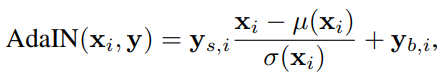\
Learned affine transformations specialize w to styles
y = (ys, yb) 

In [11]:
class AdaIN(nn.Module):
    """
    Adaptive Instance Norm
    
    params:
        channels, w_dim
    """
    
    def __init__(self, channels, w_dim):
        super().__init__()
        
        self.instanceNorm = nn.InstanceNorm2d(channels)
        self.y_s = nn.Linear(w_dim, channels)             # Style Scale
        self.y_b = nn.Linear(w_dim, channels)             # Style Bias
        
        
    def forward(self, x, w):
        x = self.instanceNorm(x)
        y_s = self.y_s(w).unsqueeze(2).unsqueeze(3)
        y_b = self.y_b(w).unsqueeze(2).unsqueeze(3)
        return y_s * x + y_b
        

In [12]:
def testAdaIN():
    noise = torch.rand(1, 3, 28, 28).to(DEVICE)
    w = torch.rand(1, 14).to(DEVICE)
    print(noise.shape)
    ad = AdaIN(3, 14).to(DEVICE)
    ans = ad(noise, w)
    print(ans.shape)
    assert ans.shape == torch.Size([1, 3, 28, 28])
    
testAdaIN()
    

torch.Size([1, 3, 28, 28])
torch.Size([1, 3, 28, 28])


## Inject Noise *B*

In [13]:
class InjectNoise(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        return x + noise

In [14]:
def testInjectNoise():
    noise = torch.rand(2, 512, 8, 8)
    inj = InjectNoise()
    ans = inj(noise)
    print(ans.shape)
    
testInjectNoise()

torch.Size([2, 512, 8, 8])


## Generator Block

In [15]:
class GenBlock(nn.Module):
    """
    Generator Block
    
    params:
        in_channels,
        out_channels,
        w_dim
    """
    
    def __init__(self, in_channels, out_channels, w_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        self.leakyReLU = nn.LeakyReLU(0.2, inplace = True)
        self.adain1 = AdaIN(out_channels, w_dim)
        self.adain2 = AdaIN(out_channels, w_dim)
        
        self.inject_noise1 = InjectNoise()
        self.inject_noise2 = InjectNoise()
        
        
    def forward(self, x, w):
        
        x = self.inject_noise1(self.conv1(x))
        x = self.leakyReLU(x)
        x = self.adain1(x, w)
        
        x = self.inject_noise2(self.conv2(x))
        x = self.leakyReLU(x)
        x = self.adain2(x, w)
        
        return x

In [16]:
def testGenBlock():
    noise = torch.rand(2, 128, 4, 4).to(DEVICE)
    genb = GenBlock(128, 64, 512).to(DEVICE)
    w = torch.rand(1, 512).to(DEVICE)
    upscaled = nn.Upsample(scale_factor = 2, mode = "nearest")(noise)
    ans = genb(upscaled, w)
    print(ans.shape)
    
testGenBlock()

torch.Size([2, 64, 8, 8])


## Generator *g*

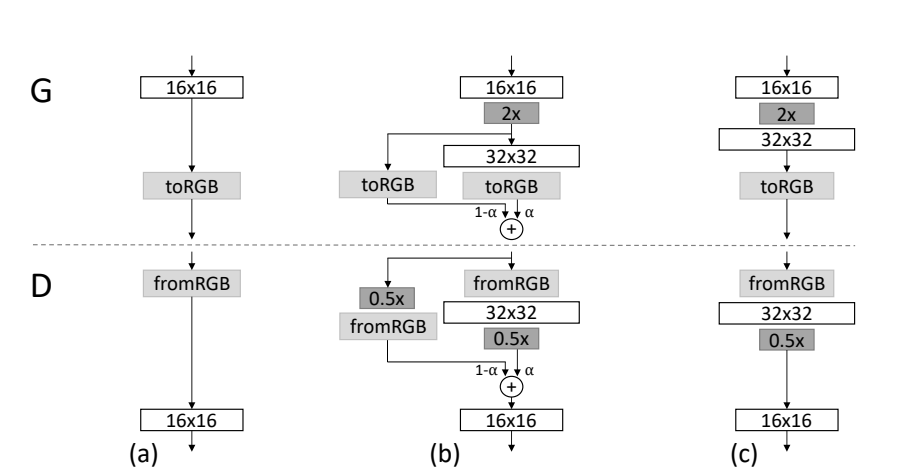

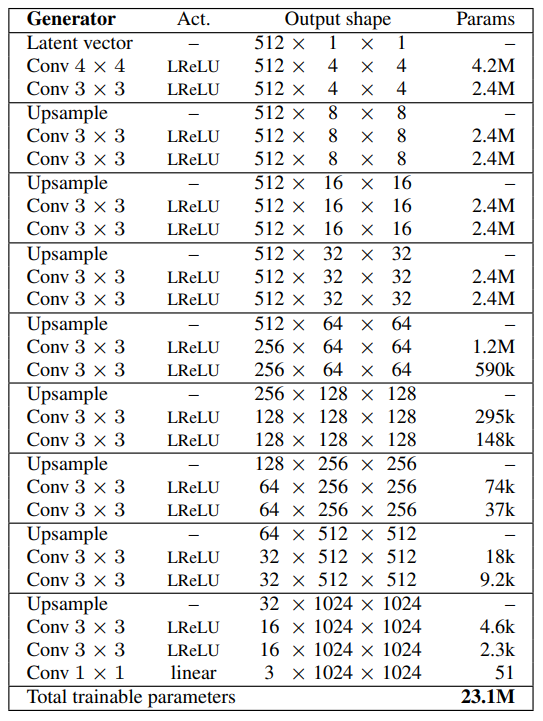

### source: [ProGAN Paper](https://arxiv.org/pdf/1710.10196.pdf)

In [17]:
factors = [1, 1, 1, 1/2, 1/4, 1/8, 1/16, 1/32]

In [18]:
class Generator(nn.Module):
    """
    The Generator: Synthesis network g
    
    params:
        z_dim, 
        w_dim,
        in_features,
        img_channels,
        img_quality,
    """
    
    def __init__(self, z_dim, w_dim, in_features, img_channels = 3, img_quality = 1024):
        super().__init__()
        self.fixed_noise = nn.Parameter(torch.ones(1, in_features, 4, 4))
        self.noise_inj1 = InjectNoise()
        
        self.conv1 = nn.Conv2d(in_features, in_features, kernel_size = 3, padding = 1, stride = 1)
        self.leakyReLU = nn.LeakyReLU(0.2, inplace = True)
        
        self.noise_inj2 = InjectNoise()
        
        self.adain1 = AdaIN(in_features, w_dim)
        self.adain2 = AdaIN(in_features, w_dim)
        
        self.mapNet = MapNet(z_dim, w_dim)
        self.pixelNorm = PixelNorm()
        
        
        self.prog_list = nn.ModuleList([])
        
        self.rgb_list = nn.ModuleList([nn.Conv2d(in_features, img_channels, kernel_size = 3, stride = 1, padding = 1)])
        
        for i in range(int(log2(1024))-3):
            self.prog_list.append(GenBlock(
                                        int(factors[i]*in_features), 
                                        int(factors[i+1]*in_features),
                                        w_dim
                                        )
                                 )
            self.rgb_list.append(nn.Conv2d(int(factors[i+1]*in_features), img_channels, kernel_size = 3, stride = 1, padding = 1))
        
        
        
    def forward(self, z, alpha, steps):
        ### Initail Block
        
        w = self.mapNet(self.pixelNorm(z))
        x = self.adain1(self.noise_inj1(self.fixed_noise), w)
        x = self.adain2(self.noise_inj2(self.leakyReLU(self.conv1(x))), w)
        
        
        ### further blocks
        if steps == 0:
            return self.rgb_list[0](x)
        
        for step in range(steps):
            
            upscaled = nn.Upsample(scale_factor = 2, mode = "nearest")(x)
            x = self.prog_list[step](upscaled, w)
            
        upscaled_rgb = self.rgb_list[steps-1](upscaled)
        final_rgb = self.rgb_list[steps](x)
        
        return torch.tanh(alpha * final_rgb + (1-alpha ) * upscaled_rgb)
  
        

In [19]:
def testGen():
    z = torch.rand(1, 512).to(DEVICE)
    gen = Generator(512, 512, 512).to(DEVICE)
    ans = gen(z, 0.1, 7)
    print(ans.shape)
#     assert ans.shape == torch.Size([1, 3, 128, 128])
testGen()

torch.Size([1, 3, 512, 512])


## Discriminator

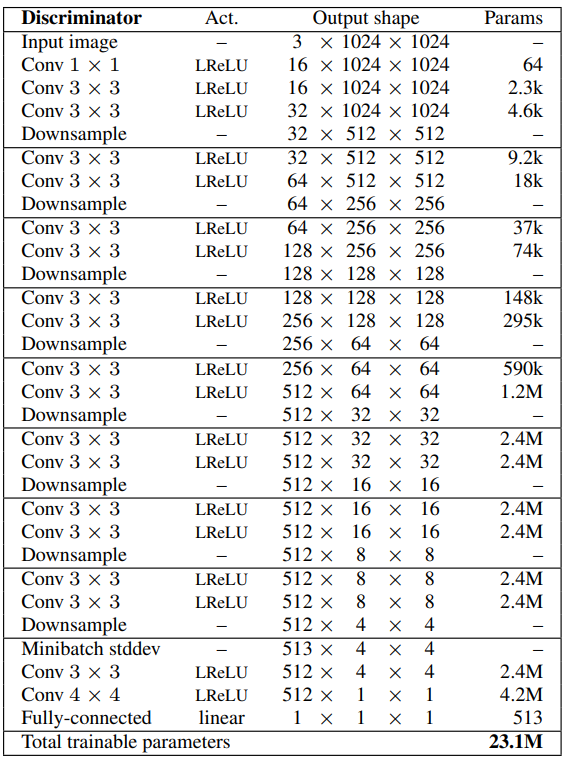

In [20]:
class DiscBlock(nn.Module):
    
    def __init__(self, in_features, out_features):
        super().__init__()
        self.conv1 = nn.Conv2d(in_features, out_features, kernel_size = 3, padding = 1, stride = 1)
        self.conv2 = nn.Conv2d(out_features, out_features, kernel_size = 3, padding = 1, stride = 1)
        self.leaky = nn.LeakyReLU(0.2, inplace = True)
        
    def forward(self, x):
        return self.leaky(self.conv2(self.leaky(self.conv1(x))))
       
        

In [21]:
class Discriminator(nn.Module):
    """
    The Discriminator
        
    """
    
    def __init__(self, in_channels, img_channels = 3):
        super().__init__()
        
        self.progblocks = nn.ModuleList([])
        self.rgb_blocks = nn.ModuleList([])
        
        self.AvgPool2d = nn.AvgPool2d(kernel_size=2, stride=2)
        self.leaky = nn.LeakyReLU(0.2, inplace = True)
        
        self.finalBlock = nn.Sequential(
            nn.Conv2d(in_channels + 1, in_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels, in_channels, kernel_size = 4, stride = 1, padding = 0),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),
            
        )
        
        
        self.rgb_blocks.append(nn.Conv2d(3, 16, kernel_size = 1, stride = 1, padding = 0)) # for 1024 image
        self.progblocks.append(
            nn.Sequential(
                nn.Conv2d(16, 16, kernel_size = 3, stride = 1, padding = 1),
                nn.Conv2d(16, 32, kernel_size = 3, stride =1, padding = 1)
            )
        )
        
        
        for i in range(1,len(factors) - 1):
            self.rgb_blocks.append(nn.Conv2d(3, int(in_channels*factors[-i-1]), kernel_size = 1, stride = 1, padding = 0))
            self.progblocks.append(DiscBlock(int(in_channels*factors[-i-1]), int(in_channels*factors[-i-2])))
            
        self.rgb_blocks.append(nn.Conv2d(3, int(in_channels*factors[-i-1]), kernel_size = 1, stride = 1, padding = 0))
        self.progblocks.append(DiscBlock(int(in_channels*factors[-i-1]), int(in_channels*factors[-i-1])))
        
        self.rgb_blocks.append(nn.Conv2d(3, int(in_channels*factors[-i-1]), kernel_size = 1, stride = 1, padding = 0))
     
    
    
    
    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        return torch.cat([x, batch_statistics], dim=1)
    
    
    
    
    def fade_in(self, downsampled, out, alpha):
        return alpha * out + (1-alpha) * downsampled
    
    
    
    
    
    def forward(self, x, alpha, steps):
        curr_step = len(factors) - steps
        
        if steps == 0: # for 4x4 image
            out = self.leaky(self.rgb_blocks[curr_step](x))
            out = self.minibatch_std(out)
            out = self.finalBlock(out).view(out.shape[0], -1)
            return out
#         print(x.shape)
        downsampled = self.AvgPool2d(x)
        downsampled = self.rgb_blocks[curr_step + 1](downsampled) # downsampled
        
        out = self.leaky(self.rgb_blocks[curr_step](x))
        out = self.AvgPool2d(self.progblocks[curr_step](out))
        out = self.fade_in(downsampled, out, alpha)

        
        for i in range(curr_step + 1, len(factors)):
            out = self.progblocks[i](out)
            out = self.AvgPool2d(out)

            
        out = self.minibatch_std(out)
        out = self.finalBlock(out).view(out.shape[0], -1)        
        return out      
        
        

In [22]:
def testDisc():
    noise = torch.rand(1, 3, 1024,1024).to(DEVICE)
    dic = Discriminator(512).to(DEVICE)
    ans = dic(noise, 0.1,8)
    print(ans.shape)
#     assert ans.shape == torch.Size([1, 3, 128, 128])
testDisc()

torch.Size([1, 1])


In [23]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import os

In [24]:
def get_loader(size):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)],
            [0.5 for _ in range(CHANNELS_IMG)],
        )        
    ])
    
    batch_size = BATCH_SIZE[int(log2(size/4))]
    dataset = datasets.ImageFolder(root = data_dir, transform = transform,)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle = True)
    return loader, dataset

In [25]:
def gradientPenalty(critic, real, fake, alpha, train_step, device = "cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)
    
    mixed_scores = critic(interpolated_images, alpha, train_step)
    
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [26]:
def saveModle(gen, critic, opt_gen, opt_critic, loss_gen, loss_critic, alpha, epoch, step):
    checkpoint = {
            'epoch': epoch,
            'gen_state_dict': gen.state_dict(),
            "critic_state_dict": critic.state_dict(),
            'opt_gen_state_dict': opt_gen.state_dict(),
            "opt_critic_state_dict" : opt_critic.state_dict(),
            'loss_gen': loss_gen,
            "loss_critic": loss_critic,
            "alpha": alpha,
            "step": step
            }
    if not os.path.exists(os.path.join(SAVE_MODEL_PATH)):
        os.mkdir(os.path.join(SAVE_MODEL_PATH)) 
    if not os.path.exists(os.path.join(SAVE_MODEL_PATH, str(step))):
        os.mkdir(os.path.join(SAVE_MODEL_PATH, str(step)))
    torch.save(checkpoint, os.path.join(SAVE_MODEL_PATH , str(step), str(epoch) +".pth"))

In [68]:
def loadModel(gen, critic, opt_gen, opt_critic):
    print("LOADING MODEL...")
    model_path = os.listdir(LOAD_MODEL_PATH)[-1]
    checkpoint = torch.load(os.path.join(LOAD_MODEL_PATH, model_path), map_location = torch.device(DEVICE))
    epoch = checkpoint["epoch"]
    gen.load_state_dict(checkpoint["gen_state_dict"])
    critic.load_state_dict(checkpoint["critic_state_dict"])
    opt_gen.load_state_dict(checkpoint["opt_gen_state_dict"])
    opt_critic.load_state_dict(checkpoint["opt_critic_state_dict"])
    loss_gen = checkpoint["loss_gen"]
    loss_critic = checkpoint["loss_critic"]
    alpha = checkpoint["alpha"]
    step = checkpoint["step"]
    print("MODEL LOADED")
    
    return gen, critic, opt_gen, opt_critic, loss_gen, loss_critic, alpha, epoch, step

In [28]:
def train(
    gen,
    critic,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
    epoch
):
    loop = tqdm(loader, leave = True)
    
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0] 
        noise = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
        fake = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradientPenalty(critic, real, fake, alpha, step, DEVICE)
        
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )
    
        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()
        
        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)
        
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        alpha += cur_batch_size / (
            EPOCHS * 0.5 * len(dataset)
        )
        alpha = min(alpha,1)
    
    saveModle(gen, critic, opt_gen, opt_critic, loss_gen, loss_critic, alpha, epoch, step)
    
    return alpha

In [29]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'/kaggle/working/saved_examples/step{steps}'):
                os.makedirs(f'/kaggle/working/saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"/kaggle/working/saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [64]:
for i in opt_gen.state:
    opt_gen.state[i]["exp_avg"].to(DEVICE)

In [56]:
for i in opt_gen.state:
    temp = opt_gen.state[i]["step"]
    temp.to(DEVICE)
    opt_gen.state[i]["step"] = temp

In [69]:
gen = Generator(
    Z_DIM, W_DIM, IN_CHANNELS, CHANNELS_IMG
)

critic = Discriminator(IN_CHANNELS, CHANNELS_IMG)

opt_gen = optim.Adam(gen.parameters(), lr=LR, betas =(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr= LR, betas =(0.0, 0.99)
)

if load_saved_model:
    gen, critic, opt_gen, opt_critic, loss_gen, loss_critic, alpha, epoch_start, step_start = loadModel(gen, critic, opt_gen, opt_critic)

    gen.to(DEVICE)
    critic.to(DEVICE)
    for i in opt_gen.state:
        opt_gen.state[i]["exp_avg"].to(DEVICE)
    for i in opt_critic.state:
        opt_critic.state[i]["exp_avg"].to(DEVICE)
    
    
    for s in range(step_start, len(factors)-1):
        loader, dataset = get_loader(4*2**s)
        print('Curent image size: '+str(4*2**s))

        for epoch in range(epoch_start, EPOCHS):
            print(f'Epoch [{epoch + 1}/ {EPOCHS}')
            alpha = train(
                gen, critic, loader, dataset, s, alpha, opt_critic, opt_gen, epoch
            )

        generate_examples(gen, s)
    
    
    
    
    
else:    
    gen.to(DEVICE)
    critic.to(DEVICE)


    gen.train()
    critic.train()


    step = int(log2(start_with_img_size / 4))
    for s in range(step, len(factors)-1):
        alpha = 1e-7
        loader, dataset = get_loader(4*2**s)
        print('Curent image size: '+str(4*2**s))
        
        for epoch in range(EPOCHS):
            print(f'Epoch [{epoch + 1}/ {EPOCHS}]')
            alpha = train(
                gen, critic, loader, dataset, s, alpha, opt_critic, opt_gen, epoch
            )

        generate_examples(gen, s)

LOADING MODEL...
MODEL LOADED
Curent image size: 16
Epoch [16/ 30


  0%|          | 0/407 [00:03<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [1]:
print("Hello")

Hello
